<a href="https://colab.research.google.com/github/guirangel03/Projeto-1---Taxa-de-aprendizado-RNA/blob/main/Projeto_1_Guilherme_Rangel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importando bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Verificar se há GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Ruído gaussiano
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

# Dataset transformado
transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.5),  # Adicionando ruído
    transforms.Normalize((0.1307,), (0.3081,)) # média e desvio padrão, respectivamente
])

# Carregar dados
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True) #há 10000 disponíveis
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False) #há 60000 disponíveis

Usando dispositivo: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.91MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.92MB/s]


In [ ]:
# MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Definindo funções para treino e teste
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

trained_models = {}  # Novo dicionário para armazenar modelos treinados

In [ ]:
learning_rates = [0.1, 0.01, 0.001] # Avaliando o comportamento sob taxas de aprendizado diferente

epochs_per_lr = {0.1: 10, 0.01: 50, 0.001: 100}
results = {}
trained_models = {}

for lr in learning_rates:
    print(f"\nTreinando com taxa de aprendizado: {lr}")
    model = MLP().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    train_losses = []
    test_accuracies = []

    for epoch in range(1, epochs_per_lr[lr] + 1):
        loss = train(model, device, train_loader, optimizer, epoch)
        acc = test(model, device, test_loader)
        train_losses.append(loss)
        test_accuracies.append(acc)
        if epoch % max(1, epochs_per_lr[lr] // 10) == 0:
            print(f"Época {epoch}: Loss={loss:.4f}, Acurácia={acc:.2f}%")

    results[lr] = {
        'losses': train_losses,
        'accuracies': test_accuracies
    }

    trained_models[lr] = model # salvando o modelo treinado


Treinando com taxa de aprendizado: 0.1
Época 1: Loss=0.5115, Acurácia=89.42%
Época 2: Loss=0.2873, Acurácia=91.96%
Época 3: Loss=0.2424, Acurácia=93.05%
Época 4: Loss=0.2178, Acurácia=92.25%
Época 5: Loss=0.1989, Acurácia=93.46%
Época 6: Loss=0.1894, Acurácia=92.57%
Época 7: Loss=0.1764, Acurácia=94.19%
Época 8: Loss=0.1746, Acurácia=94.15%
Época 9: Loss=0.1671, Acurácia=94.23%
Época 10: Loss=0.1673, Acurácia=94.91%

Treinando com taxa de aprendizado: 0.01
Época 5: Loss=0.3798, Acurácia=88.78%
Época 10: Loss=0.2681, Acurácia=91.88%
Época 15: Loss=0.2178, Acurácia=93.57%
Época 20: Loss=0.1888, Acurácia=93.93%
Época 25: Loss=0.1738, Acurácia=94.05%
Época 30: Loss=0.1619, Acurácia=94.63%
Época 35: Loss=0.1528, Acurácia=94.64%
Época 40: Loss=0.1432, Acurácia=95.20%
Época 45: Loss=0.1364, Acurácia=95.24%
Época 50: Loss=0.1316, Acurácia=95.55%

Treinando com taxa de aprendizado: 0.001
Época 10: Loss=0.5398, Acurácia=83.40%
Época 20: Loss=0.4600, Acurácia=86.14%
Época 30: Loss=0.4238, Acurác

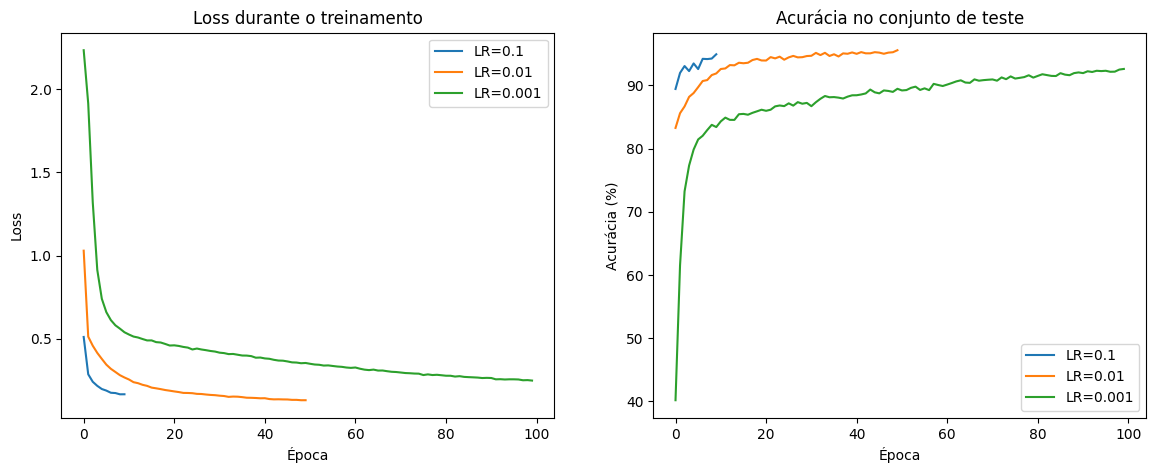

In [ ]:
# Utilizando matplotlib para plotar os gráficos
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
for lr in learning_rates:
    plt.plot(results[lr]['losses'], label=f"LR={lr}")
plt.title("Loss durante o treinamento")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
for lr in learning_rates:
    plt.plot(results[lr]['accuracies'], label=f"LR={lr}")
plt.title("Acurácia no conjunto de teste")
plt.xlabel("Época")
plt.ylabel("Acurácia (%)")
plt.legend()

plt.show()

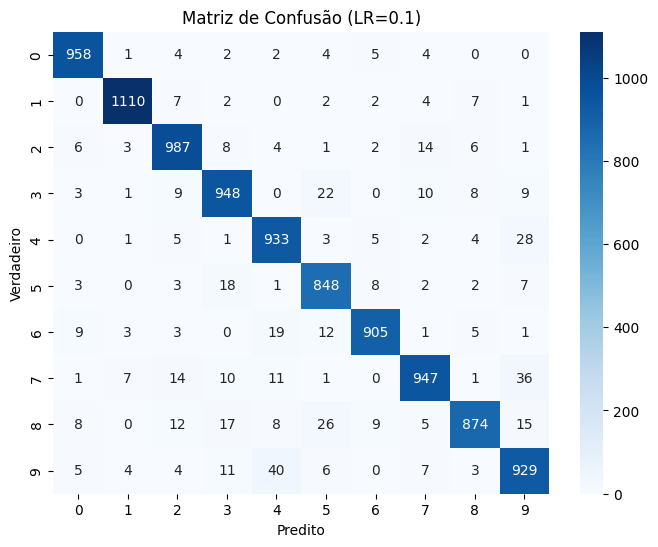

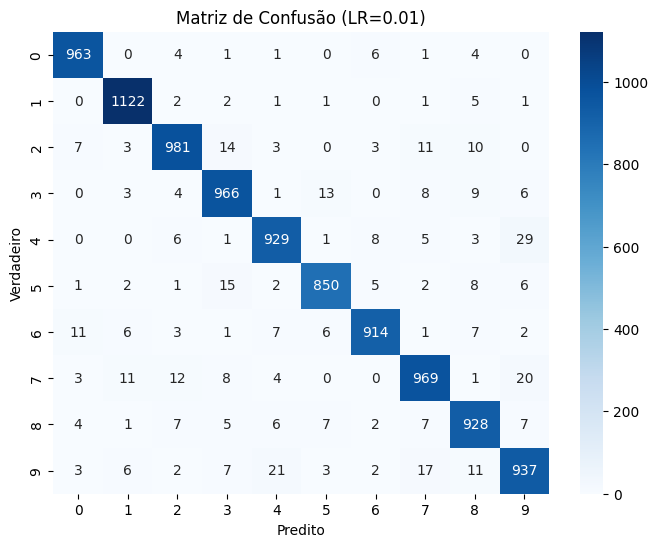

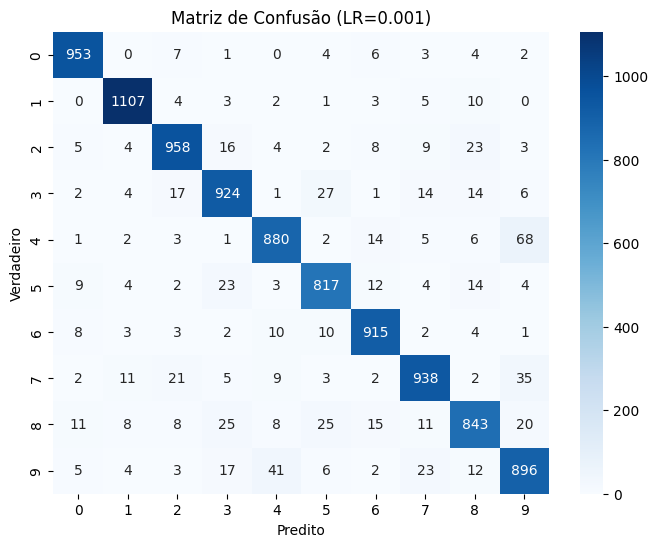

In [ ]:
# Matriz cunfusão
def plot_confusion_matrix(model, device, test_loader, lr_label):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title(f"Matriz de Confusão (LR={lr_label})")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()

for lr in learning_rates:
    model = trained_models[lr]
    plot_confusion_matrix(model, device, test_loader, lr)

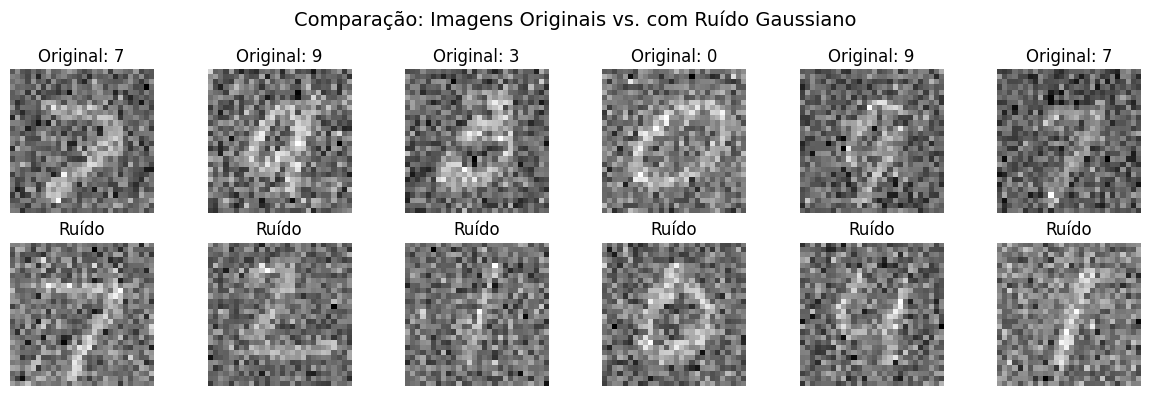

In [ ]:
# Imagens originais e com ruído gaussiano
def show_numbers(loader, num_images=6):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.suptitle("Amostras MNIST com ruído gaussiano")
    plt.show()

def compare_noisy(clean_loader, noisy_loader):
    clean_images, labels = next(iter(clean_loader))
    noisy_images, _ = next(iter(noisy_loader))

    plt.figure(figsize=(12, 4))
    for i in range(6):
        # Original
        plt.subplot(2, 6, i + 1)
        plt.imshow(clean_images[i].squeeze(), cmap='gray')
        plt.title(f"Original: {labels[i].item()}")
        plt.axis('off')

        # Com Ruído
        plt.subplot(2, 6, i + 7)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        plt.title(f"Ruído")
        plt.axis('off')

    plt.suptitle("Comparação: Imagens Originais vs. com Ruído Gaussiano", fontsize=14)
    plt.tight_layout()
    plt.show()

compare_noisy(train_loader, test_loader)
